## Imports & Setup

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Compose, Resize, RandomHorizontalFlip, Grayscale, Normalize
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from helpers import *
from architecture.Transformer import *

In [2]:
# pip install torchsampler
from torchsampler import ImbalancedDatasetSampler

In [3]:
torch.manual_seed(109)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Prepare Dataset

In [5]:
size = 32
batch_size = 128
transformation = Compose([RandomHorizontalFlip(), Grayscale(1), 
                          Resize((size, size)), ToTensor(), Normalize(mean=[0.4815], std=[0.2135])])

In [6]:
root = 'chest_xray/train'
train_data = create_dataset(root, transformation)
sampler_train = ImbalancedDatasetSampler(train_data)
train_loader = produce_loader(train_data, batch_size, sampler_train)

In [7]:
root = 'chest_xray/test'
test_data = create_dataset(root, transformation)
test_loader = produce_loader(test_data, batch_size)

In [8]:
root = 'chest_xray/val'
val_data = create_dataset(root, transformation)
val_loader = produce_loader(val_data, batch_size)

[4476, 1593, 2196, 117, 448, 3972, 817, 3857, 2073]


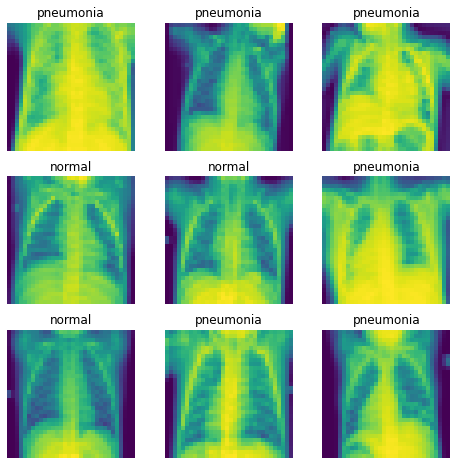

In [9]:
visualize_data(train_data)

[320, 222, 536, 502, 225, 352, 149, 124, 408]


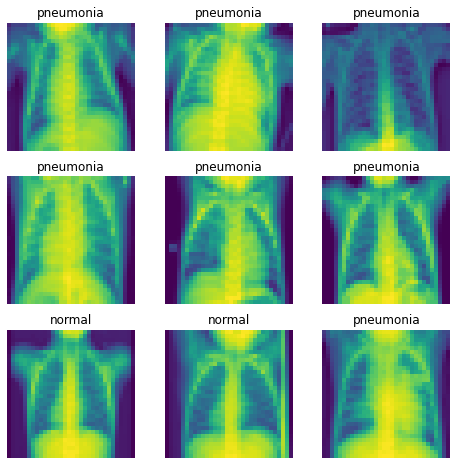

In [10]:
visualize_data(test_data)

## Initialize Model

In [11]:
def create_adam_optimizer(model, lr = 0.1, betas=(0.9, 0.999), amsgrad=False):
    return optim.Adam(model.parameters(), lr = lr, amsgrad=amsgrad, betas=betas)

In [12]:
from math import floor
# number of convolutional 'embedding' layers and their sizes
hidden = [1, 256, 64, 32]

# kernel size of convolution layers
kernel_size = 3

# window size of maxpooling layer
window = 2

# calculate final size of image
channels = hidden[-1]
changed_img = floor( (size-(kernel_size-1)*(len(hidden)-1)) / window )

# calculate dimension of flattened image
flattened = channels*changed_img*changed_img
blocks = [flattened, 512, 64]

In [13]:
model = Transformer(hidden, kernel_size, window, blocks).to(device)
print(model)

Transformer(
  (conv_combined): Sequential(
    (0): ConvEmbed(
      (conv): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
    (1): ConvEmbed(
      (conv): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
    (2): ConvEmbed(
      (conv): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
  )
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (blocks_combined): Sequential(
    (0): TransformerBlock(
      (attention): AttentionLayer(
        (query): Linear(in_features=5408, out_feat

## Training Model

In [14]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [15]:
optimizer = create_adam_optimizer(model, lr = 0.001)

In [16]:
tl, ta, vl, va = train(device, model,
                       train_loader, val_loader, 
                       optimizer, epochs = 4)
train_losses+=tl
train_accuracies+=ta
val_losses+=vl
val_accuracies+=va

Epoch 1/4, Batch number: 0, Cumulated accuracy: 0.453125
Epoch 1/4, Batch number: 5, Cumulated accuracy: 0.5338541666666666
Epoch 1/4, Batch number: 10, Cumulated accuracy: 0.5653409090909091
Epoch 1/4, Batch number: 15, Cumulated accuracy: 0.58447265625
Epoch 1/4, Batch number: 20, Cumulated accuracy: 0.6056547619047619
Epoch 1/4, Batch number: 25, Cumulated accuracy: 0.6295072115384616
Epoch 1/4, Batch number: 30, Cumulated accuracy: 0.6431451612903226
Epoch 1/4, Batch number: 35, Cumulated accuracy: 0.6603732638888888
--- Epoch 1/4: Train loss: 0.6516, Train accuracy: 0.6628
--- Epoch 1/4: Val loss: 0.6478, Val accuracy: 0.8786
Epoch 2/4, Batch number: 0, Cumulated accuracy: 0.8125
Epoch 2/4, Batch number: 5, Cumulated accuracy: 0.7747395833333334
Epoch 2/4, Batch number: 10, Cumulated accuracy: 0.7862215909090909
Epoch 2/4, Batch number: 15, Cumulated accuracy: 0.78125
Epoch 2/4, Batch number: 20, Cumulated accuracy: 0.7786458333333334
Epoch 2/4, Batch number: 25, Cumulated accurac

## Testing Model & Performance Curves

In [17]:
true_labels, model_preds, test_loss, test_accuracy = test(device, model, test_loader, get_predictions=True)

Test loss: 0.4072, Test accuracy: 0.8735


Precision: 0.8845315904139434
Recall: 0.9508196721311475
F1 score: 0.9164785553047404


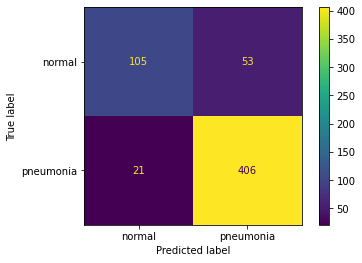

In [18]:
show_metrics(true_labels, model_preds)

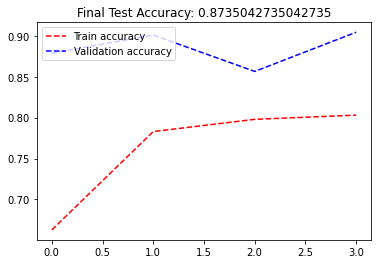

In [19]:
plt.plot(train_accuracies, "r--", label='Train accuracy')
plt.plot(val_accuracies, "b--", label='Validation accuracy')
plt.title("Final Test Accuracy: {}".format(test_accuracy))
plt.legend(loc='upper left')
plt.show()

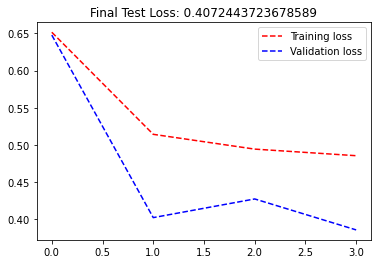

In [20]:
plt.plot(train_losses, "r--", label='Training loss')
plt.plot(val_losses, "b--", label='Validation loss')
plt.title("Final Test Loss: {}".format(test_loss))
plt.legend(loc='upper right')
plt.show()

## Viewing Model Predictions

In [21]:
test_loader2 = produce_loader(test_data, 1)

In [22]:
correct_list, wrong_list, true_labels2, model_preds2 = get_pictures_test(device, model, test_loader2)

Precision: 0.8782608695652174
Recall: 0.9461358313817331
F1 score: 0.9109357384441941


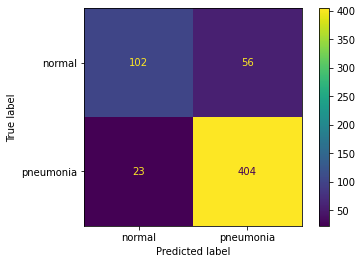

In [23]:
show_metrics(true_labels2, model_preds2)

[200, 157, 344, 295, 79, 298, 96, 239, 398, 15, 261, 157, 89, 356, 215, 315, 187, 178, 106, 468, 299, 322, 148, 143, 11]


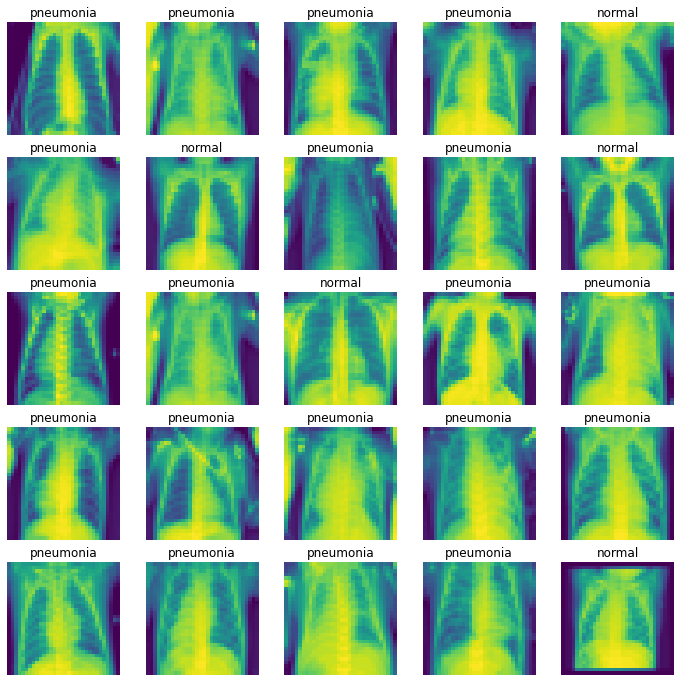

In [24]:
visualize_data(correct_list, (12,12), 5)

[78, 4, 46, 78, 19, 0, 77, 44, 12, 35, 27, 65, 18, 58, 63, 71, 15, 75, 12, 37, 10, 22, 13, 51, 27]


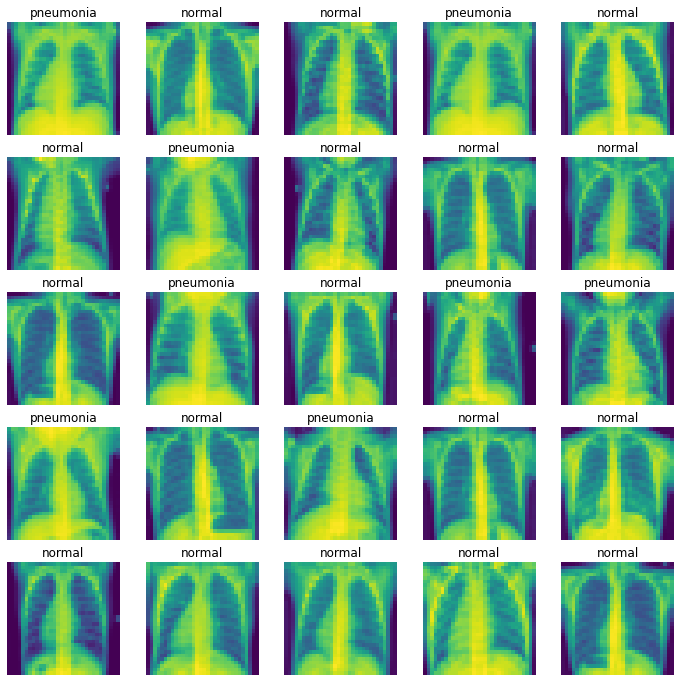

In [25]:
visualize_data(wrong_list, (12,12), 5)

## Saving Model

torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()}, 
            './transformer_512_64')